In [4]:
%matplotlib inline 

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.integrate as integrate
import scipy.special as special
from scipy.special import erf
from scipy.spatial import distance_matrix
import time
import random
import sys
import pandas as pd
import json
import os

In [5]:
random.seed(None)
np.set_printoptions(suppress=True)

In [6]:
def conc(r, t, D, nDiffDim):
    '''
    Function that calculates the concentration generated
    at a distance r by a continuously emitting point
    source after some time t given diffusion constant D
    
    Inputs
    __________
    
    r : array-like
        array of distances
    t : array-like
        array of times
    D : array-like
        diffusion constant
    nDiffDim : int-like
        number of diffusive dimensions
        
    Outputs
    __________
    
    conc : array-like
        array of concentrations
    
    '''
    
    # Calculate the concentration generated, subject
    # to the number of diffusive dimensions
    if nDiffDim == 1:
        conc = np.sqrt(t/np.pi/D)*np.exp(-r**2./4./D/t)-\
                r*special.erfc(r/np.sqrt(4.*D*t))/2./D
    
    elif nDiffDim == 2:
        conc = -special.expi(-r**2./4./D/t)/4./np.pi/D
    
    elif nDiffDim == 3:
        conc = special.erfc(r/np.sqrt(4.*D*t))/4./np.pi/D/r
        
    else:
        print("Error: make sure nDiffDims is an int with value 1, 2, or 3")

    return conc


        
def keepNearest(positionArr, nKeepers):
    '''
    Function that returns the positions in an array with
    the smallest radii
    
    Inputs
    __________
    
    positionArr : array-like
        array with the cell positions in the form
        np.array([xPositions, yPositions, zPositions, ...])
    nKeepers : int-like
        integer number of points to keep
        
        
        
    Outputs
    __________
    
    nearestLocs : array-like
        the nKeepers members of positionArr that are closest
        to the origin
    '''
    
    # Keep only the nCells points nearest to the origin
    radii = np.linalg.norm(positionArr.T, axis=1)
    keepers = np.argsort(radii)[0:nKeepers]
    nearestLocs = (positionArr.T[keepers]).T
    
    return nearestLocs



def createOrderedArray(nCellDim, sep, nCells, L):
    '''
    Function that returns an ordered array of positions
    of cells; if nCellDim is 1, then the cells are on a line;
    if nCellDim is 2, then cells are on a disk; if nCellDim is
    3, then cells are on a sphere.
    
    Inputs
    __________
    
    nCellDim : int-like
        number of dimensions in which the cells live
    sep : float-like
        separation of cells
    nCells : float-like
        number of cells
    L : array-like
        array with the size of the space
        [numSourcesInX, numSourcesInY, ...]
        
        
        
    Outputs
    __________
    
    cellPositions : array-like
        array of cell positions in the form of
        np.array([xPositions, yPositions, zPositions])
    '''
    
    # First, calculate the cell positions in 1D
    if nCellDim == 1:
        
        # Generate ordered array of positions
        cellPositions = np.array([sep*np.arange(L[0])])
    
    # Next, calculate the cell positions in 2D
    elif nCellDim == 2:
        
        # Create the x and y coordinates at which the cells live
        basisX = sep*np.arange(L[0])
        basisY = sep*(np.arange(L[1])+0.5)
        mesh = np.meshgrid(basisX, basisY)
        gridPositions = np.reshape(mesh, (2,len(basisX)*len(basisY)))
        
        # Keep only the nCells points nearest to the origin
        cellPositions = gridPositions
        
    # Next, calculate the cell positions in 3D
    elif nCellDim == 3:
        
        # Calculate maximum radius according to the given separation
        impliedR = sep*(nCells)**(1./3.)
        
        # Round up
        nR = np.ceil(impliedR/sep)
        maxR = sep*nR
        
        # Create the x and y and z coordinates at which the cells live
        basisX = sep*np.arange(L[0])
        basisY = sep*(np.arange(L[1])+0.5)
        basisZ = sep*(np.arange(L[2])+0.5)
        mesh = np.meshgrid(basisX, basisY, basisZ)
        gridPositions = np.reshape(mesh, (3,len(basisX)*len(basisY)*len(basisZ)))
        
        # Keep only the nCells points nearest to the origin
        cellPositions = gridPositions
        
    else:
        print("Error: make sure nCellDims is an int with value 1, 2, or 3")
        
    # Return the positions
    return cellPositions



def createDisorderedArray(nDim, sep, nCells, L):
    '''
    Function that returns a disordered array of positions
    of cells; if nDim is 1, then the cells are on a line;
    if nDim is 2, then cells are on a disk; if nDim is
    3, then cells are on a sphere.
    
    Inputs
    __________
    
    nDim : int-like
        number of dimensions in which the cells live
    sep : float-like
        separation of cells
    nCells : float-like
        number of cells
    L : array-like
        array with the size of the space
        [numSourcesInX, numSourcesInY, ...]
        
        
        
    Outputs
    __________
    
    cellPositions : array-like
        array of cell positions in the form of
        np.array([xPositions, yPositions, zPositions])
    '''
    
    # First, calculate the cell positions in 1D
    if nDim == 1:
        
        # Generate ordered array of positions
        cellPositions = np.array([np.random.uniform(0, sep*L[0], nCells)])
        cellPositions = np.sort(cellPositions-np.min(cellPositions))
    
    # Next, calculate the cell positions in 2D
    elif nDim == 2:
        
        # Create the x and y coordinates
        xVals = np.random.uniform(0., sep*L[0], nCells)
        yVals = np.random.uniform(0., sep*L[1], nCells)
        
        cellPositions = np.array([xVals, yVals])
        
    # Next, calculate the cell positions in 3D
    elif nDim == 3:
        
        # Create the x and y coordinates
        xVals = np.random.uniform(0., sep*L[0], nCells)
        yVals = np.random.uniform(0., sep*L[1], nCells)
        zVals = np.random.uniform(0., sep*L[2], nCells)
        
        cellPositions = np.array([xVals, yVals, zVals])
        
    else:
        print("Error: make sure nDims is an int with value 1, 2, or 3")
        
    # Return the positions
    return cellPositions

In [7]:
def singleSim(times, locs, a, D, Cth, rInv, nDiffDim, cut, updateNum, L, sep):
    '''
    Function that performs a single simulation of heaviside
    relay dynamics over an array of times given the locs of the
    point sources, emission rate a, diffusion constant D, threshold
    concentration Cth, initial radius rInv, and system dimensionality
    
    Inputs
    __________
    
    times : array-like
        times to step over
    
    locs : array-like
        locations of the point sources
        
    a : float-like
        single-source emission rate
        
    D : float-like
        diffusion constant
        
    Cth : float-like
        threshold concentration
    
    rInv : float-like
        initial signaling radius
        
    nDiffDim : int-like
        number of diffusive dimensions
        
    cut : float-like
        distance beyond the wave-front we examine in each step
    
    updateNum : int-like
        number of steps before a printed update
        
        
    Outputs
    __________
    
    activities : array-like
        array of activities of each cell in time; of the form
        [act_t=0, ..., act_t=N] with act_t=0 = [act1, ..., actM]
    
    '''
    
    locs = locs.T
    
    # Calculate the distance of each point along the wave front
    wfDist = locs.T[0]

    active = np.where(wfDist<rInv)[0]
    activeList = np.array([np.in1d(np.arange(len(locs)), active)])
    
    activeTimes = np.zeros(len(active))
    activeLocs = locs[active]
    activeWfDist = wfDist[active]
    maxActiveWfDist = max(activeWfDist)
    calcLocsTruth = np.isin(range(len(locs)), active, invert=True)*(wfDist<maxActiveWfDist+cut)
    calcLocIndices = np.where(calcLocsTruth)[0]
    calcLocs = locs[calcLocsTruth]
    
    # Propagate system in time
    for i in range(len(times)-1):
        
        oldTime = times[i]
        newTime = times[i+1]
        
        if i%updateNum == updateNum-1:
            print(i+1)
            
        dists = calcLocs-activeLocs[:,np.newaxis]
        for j in range(len(dists[0,0])):
            if j > 0:
                dists[:,:,j] = np.minimum(np.abs(dists[:,:,j]),
                                          sep*L[j]-np.abs(dists[:,:,j]))
        
        if len(calcLocIndices)!=0:
            if (len(active) != 0) & (nDiffDim == 1):
                concArr = a*np.sum(conc(np.linalg.norm(dists, axis=2),
                                        newTime-activeTimes[:,np.newaxis],
                                        D, 1), axis=0)
            elif (len(active) != 0) & (nDiffDim == 2):
                concArr = a*np.sum(conc(np.linalg.norm(dists, axis=2),
                                        newTime-activeTimes[:,np.newaxis],
                                        D, 2), axis=0)
            elif (len(active) != 0) & (nDiffDim == 3):
                concArr = a*np.sum(conc(np.linalg.norm(dists, axis=2),
                                        newTime-activeTimes[:,np.newaxis],
                                        D, 3), axis=0)
            else:
                concArr = np.zeros(len(locs))

            for k in range(len(calcLocIndices)):
                if (concArr[k] > Cth) & (calcLocIndices[k] not in active):
                    active = np.append(active[:],
                                       calcLocIndices[k])
                    activeLocs = np.append(activeLocs[:],
                                           np.array([calcLocs[k]]),
                                           axis = 0)
                    activeWfDist = np.append(activeWfDist[:],
                                            np.linalg.norm(calcLocs[k]))
                    activeTimes = np.append(activeTimes[:],
                                            newTime)

            maxActiveWfDist = max(activeWfDist)
            calcLocsTruth = np.isin(range(len(locs)), active, invert=True)*(wfDist<maxActiveWfDist+cut)
            calcLocIndices = np.where(calcLocsTruth)[0]
            calcLocs = locs[calcLocsTruth]

        activeList = np.append(activeList, np.array([np.in1d(np.arange(len(locs)), active)]), axis=0)
        if np.shape(calcLocs)[0] == 0:
            print('skip\n')
            for m in range(len(times)-i-2):
                activeList = np.append(activeList,
                                       np.array([np.in1d(np.arange(len(locs)), active)]),
                                       axis=0)
            break

    return activeList

In [12]:
### DID YOU SAVE THE PREVIOUS RUN?!??!?! ###

nRuns = 100
nCellDim = 1
nDiffDim = 1
L = np.array([300])
nCells = np.prod(L[0:nCellDim])
D = 1.
Cth = 100./1.
d = 1.
a = 2.**(nDiffDim-nCellDim)
orderType = 'disordered'

if orderType == 'disordered':
    locs = [createDisorderedArray(nCellDim, d, nCells, L) for i in range(nRuns)]
elif orderType == 'ordered':
    locs = [createOrderedArray(nCellDim, d, nCells, L) for i in range(nRuns)]

vMFMult = 1.
if nCellDim == nDiffDim:
    vMF = vMFMult*np.sqrt(a*D/Cth/d**nCellDim)
else:
    vMF = vMFMult*a/np.pi/Cth/d**nCellDim

rMax = d*L[0]
print(rMax*vMF/D)
tMax = 0.5*rMax/vMF
tRes = (D/vMF**2.)/250.
times = np.linspace(0, tMax, tMax/tRes+1)
print(len(times))

rInv = 25.*d
cut = 10.5*d
updateNum = int(len(times)/1.)

30.0
3751


In [13]:
%%time

simAct = np.array([singleSim(times, locs[i], a, D, Cth, rInv, nDiffDim, cut, updateNum, L, d)
                   for i in range(nRuns)])

skip

CPU times: user 2min 13s, sys: 10 s, total: 2min 23s
Wall time: 2min 24s


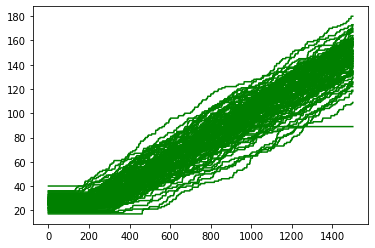

In [14]:
for i in simAct:
    plt.plot(times, np.sum(i, axis=1), 'g-')

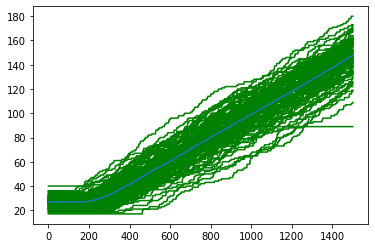

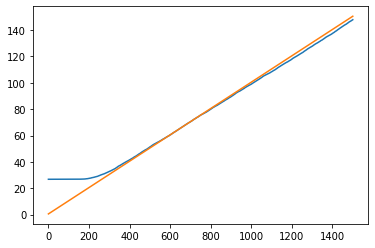

In [15]:
for i in simAct:
    plt.plot(times, d*np.sum(i, axis=1), 'g-')
plt.plot(times, d*np.mean(np.sum(simAct, axis=2), axis=0))

plt.figure()
plt.plot(times, d*np.mean(np.sum(simAct, axis=2), axis=0))
plt.plot(times, np.prod(L[1:])*vMF*times+0.5)